## 1. Example from bayesian_linear_regression.py

In [1]:
"""Bayesian linear regression using mean-field variational inference."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Normal
from scipy.stats import norm

import six
from edward.models import RandomVariable
from edward.util import get_session, get_variables, copy, kl_multivariate_normal

import time
import matplotlib.pyplot as plt

ed.set_seed(42)

In [2]:
# Function to generate synthetic data
def build_toy_dataset(N, noise_std=0.1):
    X = np.concatenate([np.linspace(0, 2, num=N / 2),
                      np.linspace(6, 8, num=N / 2)])
    y = 5.0 * X + norm.rvs(0, noise_std, size=N)
    X = X.reshape((N, 1))
    return X.astype(np.float32), y.astype(np.float32)


In [3]:
# Model setup
N = 40  # number of data points
D = 1  # number of features

# DATA
X_train, y_train = build_toy_dataset(N)
# doesn't use this part
# X_test, y_test = build_toy_dataset(N)

# MODEL
X = tf.placeholder(tf.float32, [N, D])
w = Normal(mu=tf.zeros(D), sigma=tf.ones(D))
b = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
y = Normal(mu=ed.dot(X, w) + b, sigma=tf.ones(N))

data = {X: X_train, y: y_train}

In [4]:
# INFERENCE
qw = Normal(mu=tf.Variable(tf.random_normal([D])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(mu=tf.Variable(tf.random_normal([1])),
            sigma=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

latent_vars = {w: qw, b: qb}

## 1.1 Time the single gradient evaluation

In [5]:
# Initialize session
sess = get_session()
ph = tf.placeholder(tf.float32, y_train.shape)
var = tf.Variable(ph, trainable=False, collections=[])
sess.run(var.initializer, {ph: y_train})

In [6]:
# n_samples is the number of samples in building loss function
n_samples = 1
t = tf.Variable(0, trainable=False)
increment_t = t.assign_add(1)

In [7]:
# find the list of variables
var_list = set([])
trainables = tf.trainable_variables()

for z, qz in six.iteritems(latent_vars):
    if isinstance(z, RandomVariable):
        var_list.update(get_variables(z, collection=trainables))

    var_list.update(get_variables(qz, collection=trainables))

for x, qx in six.iteritems(data):
    if isinstance(x, RandomVariable) and not isinstance(qx, RandomVariable):
        var_list.update(get_variables(x, collection=trainables))

var_list = list(var_list)

In [8]:
# build a loss function
p_log_lik = [0.0] * n_samples

z_sample = {}
for z, qz in six.iteritems(latent_vars):
    # Copy q(z) to obtain new set of posterior samples.
    qz_copy = copy(qz)
    z_sample[z] = qz_copy.value()

dict_swap = z_sample
for x, qx in six.iteritems(data):
    if isinstance(x, RandomVariable):
        if isinstance(qx, RandomVariable):
            qx_copy = copy(qx)
            dict_swap[x] = qx_copy.value()
        else:
            dict_swap[x] = qx

for x in six.iterkeys(data):
    if isinstance(x, RandomVariable):
        x_copy = copy(x, dict_swap)
        x_log_lik = tf.reduce_sum(x_copy.log_prob(dict_swap[x]))

        p_log_lik[0] += x_log_lik

p_log_lik = tf.pack(p_log_lik)

kl = tf.reduce_sum([data.get(z, 1.0) * tf.reduce_sum(kl_multivariate_normal(
                        qz.mu, qz.sigma, z.mu, z.sigma))
                    for z, qz in six.iteritems(latent_vars)])

loss = -(tf.reduce_mean(p_log_lik) - kl)

In [9]:
# benchmark the gradient time
grads = tf.gradients(loss, [v.ref() for v in var_list])[0]

init = tf.initialize_all_variables()
feed_dict = {}
for key, value in six.iteritems(data):
    if isinstance(key, tf.Tensor):
        feed_dict[key] = value
init.run(feed_dict)

In [15]:

lsclock = []
n_iter = 10000

for _ in range(n_iter):
    start_clock = time.clock()
    var_grad_val = sess.run(grads, feed_dict)
    lsclock.append(time.clock() - start_clock)

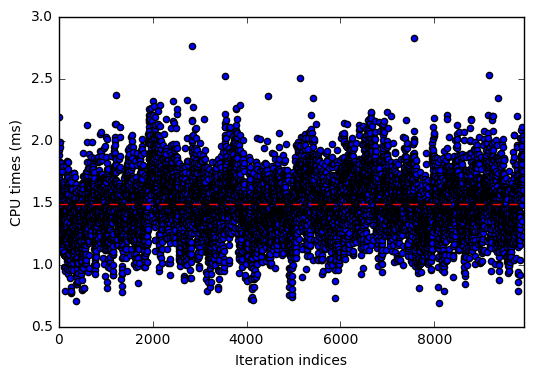

In [16]:
# plot the distribution
lsshow = map(lambda x: x * 1000, lsclock[100:])

plt.scatter(range(len(lsshow)), lsshow)
plt.hlines(np.mean(lsshow), -2, len(lsshow)+2, colors='r', linestyles='dashed')
plt.xlim(-2, len(lsshow)+2)
plt.xlabel("Iteration indices")
plt.ylabel("CPU times (ms)")
plt.show()

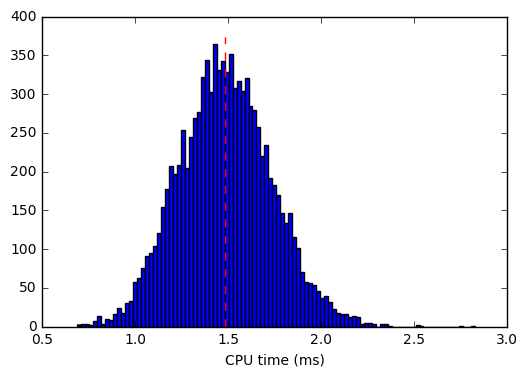

In [17]:
ax = plt.hist(lsshow, bins=100)
plt.vlines(np.mean(lsshow), 0, ax[0].max()+10, colors='r', linestyles='dashed')
plt.xlabel("CPU time (ms)")
plt.show()

## 1.2 Full model

"""#!/usr/bin/env python
   Bayesian linear regression using mean-field variational inference.
   See: https://github.com/blei-lab/edward/blob/master/examples/bayesian_linear_regression.py
"""

In [13]:
# for inference in Edward
inference = ed.KLqp({w: qw, b: qb}, data)
inference.run()

# CRITICISM
y_post = ed.copy(y, {w: qw.mean(), b: qb.mean()})
# This is equivalent to
# y_post = Normal(mu=ed.dot(X, qw.mean()) + qb.mean(), sigma=tf.ones(N))

# Test on model performance
X_test, y_test = build_toy_dataset(N)

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

Iteration    1 [  0%]: Loss = 19580.164
Iteration  100 [ 10%]: Loss = 157.399
Iteration  200 [ 20%]: Loss = 118.405
Iteration  300 [ 30%]: Loss = 104.430
Iteration  400 [ 40%]: Loss = 110.730
Iteration  500 [ 50%]: Loss = 54.611
Iteration  600 [ 60%]: Loss = 52.833
Iteration  700 [ 70%]: Loss = 52.438
Iteration  800 [ 80%]: Loss = 52.624
Iteration  900 [ 90%]: Loss = 57.160
Iteration 1000 [100%]: Loss = 56.365
Mean squared error on test data:
0.0286954
